In [22]:
# Initialize libraries and functions
from numba import jit, cuda
import warnings
import cv2
import numpy as np
import math
import random
import time as timess
from prettytable import PrettyTable
from IPython.display import clear_output, Markdown, display
from abc import ABC, abstractmethod 

def db_to_normal(x):
    return 10**(x/10)

def normal_to_db(x):
    return 10*math.log10(x)

def pdw_tabular_print(pdw,time):
    if(len(pdw)>1):
        display(Markdown('{}<strong>{}</strong>{}'.format('PDW\'s of the recieved pulses in ',str(time//10)+' nano seconds',' are as follows')))
        t = PrettyTable(list(pdw[0].keys()))
        for i in pdw[:]:
            t.add_row(list(i.values()))
        print(t)

# base_noise_min=db_to_normal(-1000)
# base_noise_max=db_to_normal(-75)
base_noise_min=db_to_normal(-1000*1000)
base_noise_max=db_to_normal(-75*1000)
ci=0#len(time)//4
cf=10000
cf=10000
fig_x , fig_y = 25 , 2
clrs= 'rgbcmyk'
rand_skew=0

In [23]:
# Initiallize tables

# rf = open("Radar_G_table.txt", "w")
# f = open("RWR_G_table.txt", "w")
# for j in range(5,185,5):
#     f.write(str(j/10))
#     f.write(' | ')
#     rf.write(str(j/10))
#     rf.write(' | ')
#     for i in range(360):
#         if((i>=0 and i<=90) or (i>=270 and i<360)):
#             f.write(str(math.cos(math.radians(i)))+' ')
#             rf.write(str(math.cos(math.radians(i)))+' ')
#         else:
#             f.write(str(0)+' ')
#             rf.write(str(0)+' ')
#     f.write('\n')
#     rf.write('\n')
# f.close()    
# rf.close()  

# f = open("angle_table.txt", "w")
# for th in range(-45,45):
#     a1=round(normal_to_db(math.cos(math.radians(45+th))),4)
#     a2=round(normal_to_db(math.cos(math.radians(45-th))),4)
#     f.write(str(round(a2-a1,5))+',')
# th=45
# a1=round(normal_to_db(math.cos(math.radians(45+th))),4)
# a2=round(normal_to_db(math.cos(math.radians(45-th))),4)
# f.write(str(round(a2-a1,5)))
# f.close()


RWR_G_table={}
f = open("RWR_G_table.txt", "r")
Lines = f.readlines()
for line in Lines:
    tmp=list(line.split())
    tmp_freq=float(tmp[0])
    tmp=tmp[2:]
    RWR_G_table[tmp_freq]=[]
    for i in tmp:
        RWR_G_table[tmp_freq].append(float(i))
f.close()

Radar_G_table={}
f = open("Radar_G_table.txt", "r")
Lines = f.readlines()
for line in Lines:
    tmp=list(line.split())
    tmp_freq=float(tmp[0])
    tmp=tmp[2:]
    Radar_G_table[tmp_freq]=[]
    for i in tmp:
        Radar_G_table[tmp_freq].append(float(i))
f.close()

f = open("angle_table.txt", "r")
angle_table=tuple(map(float,f.read().split(',')))
f.close()

In [24]:
class battle_system(ABC):
    def __init__(self):
        pass

    @abstractmethod
    def get(self):
        pass
        
    @abstractmethod
    def set(self):
        pass
        
    @abstractmethod
    def ontick(self):
        pass
    
    def __del__(self):
        pass

In [25]:
class platform(battle_system):
    def __init__(self, pos=(0,0),speed=0,onboard_systems=[]):
        super().__init__()
        self.position = pos
        self.speed = speed
        self.onboard_systems = onboard_systems
    
    def __del__(self):
        super().__del__()

In [26]:
class aircraft(platform):
    def __init__(self, id,heading=0,speed=10,aircraftWaypoints=[],onboard_systems=[]):
        super().__init__(aircraftWaypoints[0] ,speed,onboard_systems)
        self.id = id                                       # Id of the Aircraft
        self.heading = heading                             # heading of the Aircraft in degrees
        self.aircraftWaypoints=aircraftWaypoints
        self.next_waypoint=1
        
    def move_aircraft(self):
        if(len(self.aircraftWaypoints)>1):
            time_diff=1
            cur_pos=list(self.position)
            next_waypoint=self.next_waypoint
            d=math.dist(self.aircraftWaypoints[next_waypoint],cur_pos)
            idx=0
            while(d < (self.speed*time_diff)):
                idx += 1
                next_waypoint += 1
                if (next_waypoint== len(self.aircraftWaypoints)):
                    next_waypoint = 0
                if(idx>len(self.aircraftWaypoints)*2):
                    raise Exception("Aircraft speed is too much")
                d=math.dist(self.aircraftWaypoints[next_waypoint],cur_pos)
            heading=math.degrees(math.atan2(self.aircraftWaypoints[next_waypoint][1] - cur_pos[1],self.aircraftWaypoints[next_waypoint][0] - cur_pos[0]))
            while(heading>=360):
                heading-=360
            while(heading<0):
                heading+=360
            self.heading=heading
            cur_pos[0] += ((self.speed * time_diff) * (self.aircraftWaypoints[next_waypoint][0] - cur_pos[0]) / d)
            cur_pos[1] += ((self.speed * time_diff) * (self.aircraftWaypoints[next_waypoint][1] - cur_pos[1]) / d)
            self.position=cur_pos
            self.next_waypoint=next_waypoint

    def get(self):
        return self.position
        
    def set(self,speed):
        self.speed=speed
        
    def ontick(self):
        self.move_aircraft()
    
    def __del__(self):
        super().__del__()

In [27]:
class sensor(battle_system):
    def __init__(self,host_platform):
        super().__init__()
        self.host_platform = host_platform
    
    def __del__(self):
        super().__del__()

In [28]:
class radar(sensor):
    def __init__(self, id,pri=500,pwd=10,heading=0,radarWaypoints=[],signature_type='fixed',host_platform=[]):
        super().__init__(host_platform)
        self.id = id                                       # Id of the radar
        self.pri = pri                                     # Pulse Repetition Interval 1 nano seconds
        self.pwd = pwd                                     # Pulse Width in 1 nano seconds
        self.Pt = (10**1)*1                                # Peak transmitted power
        self.freq = 10.0                                   # frequency range 0.5 to 18 units gigahertz
        self.heading = heading                             # heading of the radar in degrees
        self.signature_type=signature_type[0]
        self.sig_data=signature_type
        self.impedance = 50
        self.position = radarWaypoints[0]
        self.speed=10
        self.radarWaypoints=radarWaypoints
        self.next_waypoint=1

    def move_radar(self):
        if(len(self.radarWaypoints)>1):
            time_diff=1
            cur_pos=list(self.position)
            next_waypoint=self.next_waypoint
            d=math.dist(self.radarWaypoints[next_waypoint],cur_pos)
            idx=0
            while(d < (self.speed*time_diff)):
                idx += 1
                next_waypoint += 1
                if (next_waypoint== len(self.radarWaypoints)):
                    next_waypoint = 0
                if(idx>len(self.radarWaypoints)*2):
                    raise Exception("Radar "+self.id+"'s speed is too much")
                d=math.dist(self.radarWaypoints[next_waypoint],cur_pos)
            # heading=math.degrees(math.atan2(self.radarWaypoints[next_waypoint][1] - cur_pos[1],self.radarWaypoints[next_waypoint][0] - cur_pos[0]))
            # while(heading>=360):
            #     heading-=360
            # while(heading<0):
            #     heading+=360
            # self.heading=heading
            cur_pos[0] += ((self.speed * time_diff) * (self.radarWaypoints[next_waypoint][0] - cur_pos[0]) / d)
            cur_pos[1] += ((self.speed * time_diff) * (self.radarWaypoints[next_waypoint][1] - cur_pos[1]) / d)
            self.position=cur_pos
            self.next_waypoint=next_waypoint

    def get(self):
        return self.position
        
    def set(self,speed,heading):
        self.speed=speed
        self.heading=heading
        
    def ontick(self):
        self.move_radar()
    
    def __del__(self):
        super().__del__()

In [29]:
class rwr(sensor):
    def __init__(self, number_of_antennas,host_platform):
        super().__init__(host_platform)
        self.number_of_antennas=number_of_antennas
        self.threats=[]
        self.pdws=[]
        self.emitter_records=[]

    def emitter_records_generator(self,radars,time,itime):
        pdws=self.generate_pdw(radars,time,itime)
        emitters=[]
        emitters_set=set()
        for i in pdws[0]:
            if(i['Emitter ID'] not in emitters_set):
                if(i['AOA']!='NA' and i['Frequency (GHz)']!=0):
                    rec_power=math.sqrt(i['A1 (dbm)']**2+i['A2 (dbm)']**2+i['A3 (dbm)']**2+i['A4 (dbm)']**2)
                    rec_power=round(((i['A1 (dbm)']+i['A2 (dbm)']+i['A3 (dbm)']+i['A4 (dbm)'])/2),5)
                    # rec_power=max(i['A1 (dbm)'],i['A2 (dbm)'],i['A3 (dbm)'],i['A4 (dbm)'])
                    emitters.append([i['Emitter ID'],True,i['Frequency (GHz)'],i['AOA'],rec_power])
                    emitters_set.add(i['Emitter ID'])
        return (emitters,pdws)

    def signal_generator(self,radar,i):
        global RWR_G_table,Radar_G_table,angle_table,base_noise_min,base_noise_max,time,receivers_n,rwr_antenna_n,rand_skew
        pri = radar.pri                               # Pulse Repetition Interval
        pwd = radar.pwd                               # Pulse Width
        R = math.dist(radar.position,self.host_platform.position)*100      # Distance between the radar and the aircraft
        if(R<1):
            R=1
        Pt = radar.Pt                                 # Peak transmitted power
        freq = radar.freq                             # carrier frequency
        signature_type=radar.signature_type
        sig_data=radar.sig_data
        # Lambda=3*(10**8)/radar.freq
        Lambda=2
        angle=math.degrees(math.atan2(radar.position[1]-self.host_platform.position[1],radar.position[0]-self.host_platform.position[0]))-self.host_platform.heading
        while(angle>=360):
            angle-=360                                     # Angle between the aircraft's front direction and radar
        while(angle<0):
            angle+=360
        angle_rad = radar.heading
        angle_t=int(angle-angle_rad-180-(360-self.host_platform.heading))
        while(angle_t>=360):
            angle_t-=360                                     # Angle between the radar's boresight and aircraft
        while(angle_t<0):
            angle_t+=360
        angle_radar = angle_t
        P=(Pt*Radar_G_table[freq][angle_t]*(Lambda**2))/((4*math.pi*R)**2)  # Power recieved by the aircraft radar reciver
        a=0.1
        omega=2*np.pi*18/10
        angl_cond=[]
        loss=8
        pulse_train_angles=[]
        pulse_train_frequency=[]
        pulse_train=[]                                   # we are producing the pulse train for the 4 recievers
        for j in range(receivers_n):                          # front left, rear left, rear right and front right respectively
            angl_cond.append((360/receivers_n)*(1+2*j)/2)     # based on the above information
            pulse_train.append([])
        for j in range(rwr_antenna_n-receivers_n):
            pulse_train.append([])
        if(signature_type=='skew'):
            if(i%pri==pri-pwd):
                rand_skew=int(random.uniform(0,2*pwd//10))
            if(i%(pri+rand_skew)<=pwd):
                current_pulse=True
            else:
                current_pulse=False
        elif(signature_type=='jittered'):
            if(i%pri==pri-pwd):
                rand_skew=int(random.uniform(0,2*pwd))
            if(i%(pri+rand_skew)<=pwd):
                current_pulse=True
            else:
                current_pulse=False
        elif(signature_type=='staggered'):
            total_pri=sum(sig_data[1])#+sig_data[1][0]
            t_pri=0
            for k in range(len(sig_data[1])):
                sub_pri=sig_data[1][k]
                if(i%total_pri>=(sub_pri+t_pri-pwd) and i%total_pri<=(sub_pri+t_pri)):
                    current_pulse=True
                    break
                else:
                    current_pulse=False
                t_pri+=(sig_data[1][k])
        elif(signature_type=='switcher'):
            total_pri=0
            for k in sig_data[1]:
                total_pri+=k[0]*k[1]
            t_pri=0
            for k in sig_data[1]:
                break_flag=False
                for l in range(k[0]):
                    sub_pri=k[1]
                    if(i%total_pri>=(sub_pri*l+t_pri) and i%total_pri<=((sub_pri*l+t_pri)+pwd)):
                        current_pulse=True
                        break_flag=True
                        break
                    else:
                        current_pulse=False
                if(break_flag):
                    break
                t_pri+=(k[0]*k[1])
        else:
            if(i%pri<=pwd):
                current_pulse=True
            else:
                current_pulse=False
        if(current_pulse):            
            idx=0
            jdx=0
            for j in pulse_train:
                tmp_n=random.uniform(base_noise_min,base_noise_max)
                tmp_v=abs(P*RWR_G_table[freq][int(angle-angl_cond[idx])])
                tmp_f=tmp_n if tmp_v<base_noise_max else tmp_v*(1+a*(np.sin(omega*i)-1))
                j.append(tmp_f)
                if(tmp_v>base_noise_max):
                     if(normal_to_db(tmp_v*1000)>-75):
                         jdx+=1
                idx+=1
            if(jdx==2):
                pulse_train_angles.append(radar.id)
                pulse_train_frequency.append(freq)
            else:
                pulse_train_angles.append(0)
                pulse_train_frequency.append(0)
        else:
            pulse_train_angles.append(0)
            pulse_train_frequency.append(0)
            for j in pulse_train:
                j.append(random.uniform(base_noise_min,base_noise_max))
        return pulse_train,pulse_train_angles,pulse_train_frequency

    def generate_pdw(self,radars,time,itime):
        frame = np.zeros((500,1000,3), np.uint8)
        pulse_train_angles=[]
        pulse_train_frequency=[]
        pulse_train=[]
        pulse_train_f=[]
        for j in range(rwr_antenna_n):
            pulse_train.append([])
            for i in range(len(radars)):
                pulse_train[-1].append([])
            pulse_train_f.append([])
        mov_offset=0
        tmp_pdw={}
        pdw=[]
        counter=[]
        max_amplitude=[]
        list_init=[]
        fall_flag=[]
        lead_flag=[]
        increasing_count=[]
        increasing_flag=[]
        top_points=[]
        for j in range(rwr_antenna_n):
            counter.append(0)
            max_amplitude.append(0)
            increasing_count.append(0)
            list_init.append([])
            top_points.append([])
            increasing_flag.append(0)
            fall_flag.append(True)
            lead_flag.append(True)
        start_time=itime*time
        idx=start_time
        time+=start_time
        play_flag=True
        visualize_graph=0
        while idx<time:
            if(play_flag):
                airc_pos=(int(self.host_platform.position[0]),int(self.host_platform.position[1]))
                max_t=[]
                max_t_a=set()
                max_t_f=set()
                for j in range(rwr_antenna_n):
                    max_t.append([])
                for j in range(len(radars)):
                    radar_pos=(int(radars[j].position[0]),int(radars[j].position[1]))
                    heading_angle=int(math.degrees(math.atan2(airc_pos[1]-radar_pos[1],airc_pos[0]-radar_pos[0])))
                    heading_noise_range=0
                    # radars[j].heading=heading_angle#random.randint(heading_angle-heading_noise_range,heading_angle+heading_noise_range)
                    pulse_train_r,pulse_train_angles_r,pulse_train_frequency_r=self.signal_generator(radars[j],idx)
                    for k in range(len(pulse_train_r)):
                        max_t[k].append(pulse_train_r[k][0])
                        pulse_train[k][j].append(pulse_train_r[k][0])
                    if(pulse_train_angles_r[0]!=0):
                        max_t_a.add(pulse_train_angles_r[0])
                    if(pulse_train_frequency_r[0]!=0):
                        max_t_f.add(pulse_train_frequency_r[0])

                if(visualize_graph):
                    if(idx>=frame.shape[1]-1):
                        off_spd=1
                        mov_offset+=off_spd
                        tmp=frame[:,off_spd:,:].copy()
                        frame[:,:-off_spd,:]=tmp.copy()
                # generating th pdw's
                if(len(max_t_a)==1):
                    pulse_train_angles.append(list(max_t_a)[0])
                else:
                    pulse_train_angles.append(0)
                if(len(max_t_a)==1):
                    pulse_train_frequency.append(list(max_t_f)[0])
                else:
                    pulse_train_frequency.append(0)
                all_fall=0
                tmp_counter=[]
                tmp_amplitude=[]
                for j in range(len(max_t)):
                    pulse_train_f[j].append(max(max_t[j]))
                    if(visualize_graph):
                        if(idx>0):
                            # drawing the graph on the image
                            cv2.line(frame,
                                     (idx-mov_offset,frame.shape[0]*(j+1)//4-int(pulse_train_f[j][idx-1-start_time]*10000000)-10),
                                     (idx-mov_offset,frame.shape[0]*(j+1)//4-int(pulse_train_f[j][ idx -start_time]*10000000)-10),
                                     (0,0,255),1)
                    if(pulse_train_f[j][-1]>base_noise_max):
                        if(normal_to_db(pulse_train_f[j][-1]*1000)>-75):
                            if not(lead_flag[j]):
                                lead_flag[j]=True # Rising edge
                                if(len(tmp_pdw)==0):
                                    tmp_pdw['TOA']=idx
                            if(pulse_train_f[j][-1]>max_amplitude[j]):
                                max_amplitude[j]=pulse_train_f[j][-1]
                            counter[j]+=1
                            fall_flag[j]=False
                        else:
                            if not(fall_flag[j]):
                                fall_flag[j]=True # Falling edge
                                tmp_counter.append(counter[j])
                            tmp_amplitude.append(max_amplitude[j])
                            lead_flag[j]=False
                            max_amplitude[j]=0
                            counter[j]=0
                            all_fall+=1
                    else:
                        if not(fall_flag[j]):
                            fall_flag[j]=True # Falling edge
                            tmp_counter.append(counter[j])
                        tmp_amplitude.append(max_amplitude[j])
                        lead_flag[j]=False
                        max_amplitude[j]=0
                        counter[j]=0
                        all_fall+=1
                if(all_fall==len(max_t) and len(tmp_pdw)!=0):
                    round_digits=2
                    tmp_pdw['PWD']=max(tmp_counter)-1
                    tmp_pdw['Emitter ID']=round(max(pulse_train_angles[tmp_pdw['TOA']-1-start_time:tmp_pdw['TOA']+tmp_pdw['PWD']-start_time]),2)
                    tmp_pdw['Frequency (GHz)']=round(max(pulse_train_frequency[tmp_pdw['TOA']-1-start_time:tmp_pdw['TOA']+tmp_pdw['PWD']-start_time]),2)
                    tmp_pdw['Frequency (GHz)']=abs(round(tmp_pdw['Frequency (GHz)']+(random.uniform(-0.001,0.001) if tmp_pdw['Frequency (GHz)']>0 else 0),4))
                    tmp_pdw['TOA']=tmp_pdw['TOA']+int(random.uniform(-10,10))
                    amp_unit='dbm'
                    amlitudes=[]
                    for j in range(len(max_t)):
                        amp_value=tmp_amplitude[j]
                        if(amp_value==0):
                            amp_value=0
                        else:
                            amp_value=normal_to_db(amp_value*1000)+85
                            amp_value=round(amp_value,5)
                        amlitudes.append(amp_value)
                        if(j==0):
                            tmp_pdw['A1 ('+str(amp_unit)+')']=(amp_value)
                        elif(j==1):
                            tmp_pdw['A2 ('+str(amp_unit)+')']=(amp_value)
                        elif(j==2):
                            tmp_pdw['A3 ('+str(amp_unit)+')']=(amp_value)
                        elif(j==3):
                            tmp_pdw['A4 ('+str(amp_unit)+')']=(amp_value)
                    amp_ind=[]
                    amp_cnt=0
                    AOA=[]
                    for amps in amlitudes:
                        amp_cnt+=1
                        if amps > 10:
                            amp_ind.append(amp_cnt)
                            AOA.append(amps)
                    if(len(amp_ind)==2):
                        if(amp_ind[0]==1 and amp_ind[1]==4):
                            t_ang=360-((np.abs(np.asarray(angle_table) - round(AOA[1]-AOA[0],round_digits))).argmin()-45)
                            if(t_ang>=360):
                                t_ang-=360
                            tmp_pdw['AOA']=t_ang
                        elif(amp_ind[0]==1 and amp_ind[1]==2):
                            tmp_pdw['AOA']=90+((np.abs(np.asarray(angle_table) - round(AOA[1]-AOA[0],round_digits))).argmin()-45)
                        elif(amp_ind[0]==2 and amp_ind[1]==3):
                            tmp_pdw['AOA']=180+((np.abs(np.asarray(angle_table) - round(AOA[1]-AOA[0],round_digits))).argmin()-45)
                        elif(amp_ind[0]==3 and amp_ind[1]==4):
                            tmp_pdw['AOA']=270+((np.abs(np.asarray(angle_table) - round(AOA[1]-AOA[0],round_digits))).argmin()-45)
                        else:
                            tmp_pdw['AOA']='NA'
                    else:
                        tmp_pdw['AOA']='NA'
                    # tmp_pdw['Freq_mod_flag']=False

                    pdw.append(tmp_pdw)
                    tmp_pdw={}
                idx+=1
            if(visualize_graph):
                if(idx%100==0):
                    print(idx/time)
                    clear_output(wait=True)
                cv2.imshow('Test', frame)
                quit_k = cv2.waitKey(1) & 0xF
                if quit_k == ord('p'):
                    play_flag=False
                if quit_k == ord('l'):
                    play_flag=True

        if(visualize_graph):
            cv2.destroyAllWindows()
        return pdw,pulse_train_f,pulse_train

    def get(self):
        return (self.pdws, self.emitter_records)

    def set(self):
        pass

    def ontick(self,radars=[],time=10**4,itime=0):
        output=self.emitter_records_generator(radars,time,itime)
        self.emitter_records=output[0]
        self.pdws=output[1]
        
    def __del__(self):
        super().__del__()

In [30]:
# Initialization
rwr_antenna_n = 4              # Number of recievers on the aircraft(4 or 6)
radars_n = 3                   # Number of radars
receivers_n = 4 # Effective number of antenna

img = np.zeros((700,1400,3), np.uint8)

# Aircraft object is created
aircraft_waypoints = [(336, 630), (171, 629), (167, 630), (157, 629), (151, 628), (148, 626), (144, 623), (42, 525), (38, 522), (32, 518), (29, 514), (27, 509), (27, 504), (28, 500), (30, 495), (33, 493), (45, 485), (70, 468), (265, 288), (273, 282), (275, 274), (275, 269), (273, 156), (276, 150), (281, 146), (285, 145), (289, 145), (296, 144), (615, 145), (619, 146), (626, 149), (630, 155), (633, 160), (632, 165), (633, 171), (634, 179), (633, 184), (633, 189), (633, 195), (636, 295), (636, 298), (636, 305), (636, 312), (638, 320), (640, 327), (643, 349), (648, 402), (649, 415), (649, 424), (652, 436), (652, 447), (654, 455), (656, 461), (656, 466), (655, 471), (656, 479), (655, 487), (656, 501), (654, 557), (656, 565), (652, 575), (648, 585), (638, 593), (623, 605), (616, 609), (608, 612), (595, 614), (589, 615), (578, 615), (563, 613), (553, 610), (545, 608), (533, 601), (522, 593), (515, 585), (505, 570), (500, 559), (497, 545), (497, 534), (499, 524), (503, 515), (511, 505), (520, 497), (534, 492), (546, 484), (556, 478), (574, 474), (584, 472), (597, 470), (611, 468), (627, 467), (639, 465), (655, 466), (659, 466), (683, 466), (692, 466), (723, 462), (729, 460), (740, 454), (751, 444), (757, 438), (1099, 109), (1105, 104), (1114, 99), (1121, 96), (1132, 93), (1147, 93), (1166, 93), (1177, 96), (1183, 100), (1188, 107), (1189, 112), (1191, 124), (1194, 140), (1224, 505), (1225, 514), (1225, 522), (1225, 526), (1225, 532), (1225, 547), (1226, 559), (1225, 572), (1231, 615), (1229, 626), (1226, 637), (1217, 649), (1205, 655), (1186, 660), (1165, 662), (1152, 664)]

aircraft_0 = aircraft(id=0,
                      heading=random.uniform(0,360),
                      speed=10,
                      aircraftWaypoints=aircraft_waypoints[:])

# RWR object is created

rwr_0 = rwr(number_of_antennas=receivers_n,host_platform=aircraft_0)
aircraft_0.onboard_systems=[rwr_0]

# RADAR object is created
radar_positions = np.array([
                            (655.0, 466.0),
                            (39.0, 500.0),
                            (50.0, 42.0),
                            (1355.0, 670.0),
                           ])
radar_waypoints = [[]]*len(radar_positions)
radar_waypoints = list([
                        [radar_positions[0]]#+[(829, 384), (505, 383)]
                       ,[radar_positions[1]]
                       ,[radar_positions[2]]
                       ,[radar_positions[3]]
                       ])
# radar_waypoints = list([[radar_positions[0]]])
radars_n=len(radar_waypoints)
radars=[]
#'fixed'
#'skew'
#'jittered'
#'staggered'
#'switcher'
signatures=[['fixed'],
            ['fixed'],
            ['fixed'],
            ['fixed']]
signature=['switcher',[[2,80],[4,150],[3,400]]]
signature=['staggered',[50,100,200,400]]
signature=['jittered']
signature=['skew']
signature=['fixed']
signatures=[]
for i in range(radars_n):
    signatures.append(signature)
pris=[400,550,750,920]
for j in range(radars_n):
    heading_angle=int(math.degrees(math.atan2(aircraft_0.position[1]-radar_positions[j][1],aircraft_0.position[0]-radar_positions[j][0])))#+180
    heading_noise_range=0
    rand_pri=int(random.uniform(100,1000))
    radar_j = radar(id=j+1,pri=pris[j],pwd=15,
                    heading=random.randint(heading_angle-heading_noise_range,heading_angle+heading_noise_range),
                    radarWaypoints=radar_waypoints[j],
                    signature_type=signatures[j]
                   )
    rand_freq=(int(random.uniform(0,18)))
    radar_j.freq=0.5+rand_freq
    radars.append(radar_j)
    del radar_j
    
# Visualization
print('Aircraft and it\'s description')
t = PrettyTable(['Id','Number of RWR antenna\'s'])
i=aircraft_0
t.add_row([i.id+1,i.onboard_systems[0].number_of_antennas])
print(t)
print('Radars and their description')
t = PrettyTable(['Id', 'Peak transmitted power(db)','frequency (GHZ)','Pulse Repetition Interval(100 pico seconds)','Pulse Width(100 pico seconds)','signature_type'])
for i in radars:
    t.add_row([i.id,10*math.log10(i.Pt),i.freq,i.pri,i.pwd,i.signature_type])
print(t)

Aircraft and it's description
+----+-------------------------+
| Id | Number of RWR antenna's |
+----+-------------------------+
| 1  |            4            |
+----+-------------------------+
Radars and their description
+----+----------------------------+-----------------+---------------------------------------------+-------------------------------+----------------+
| Id | Peak transmitted power(db) | frequency (GHZ) | Pulse Repetition Interval(100 pico seconds) | Pulse Width(100 pico seconds) | signature_type |
+----+----------------------------+-----------------+---------------------------------------------+-------------------------------+----------------+
| 1  |            10.0            |       2.5       |                     400                     |               15              |     fixed      |
| 2  |            10.0            |       14.5      |                     550                     |               15              |     fixed      |
| 3  |            10.0         

In [31]:
# Main Function

#Initialization
search_mode=0
search_radars={1}
play_back_speed=1
play_flag=0
resize=1.5
cv2.namedWindow("Visualisation", cv2.WINDOW_NORMAL)
cv2.resizeWindow("Visualisation", int(img.shape[1]/resize), int(img.shape[0]/resize))
tmp_s_r=20
tmp_s_a=20
aircraft_speed=10
radar_speed=1

time=(10**3)*2 #in 1 nano seconds 

visualize=True
idx=0
pdws=[]
pulse_train=[]
pulse_train_f=[]
for j in range(receivers_n):
    pulse_train.append([])
    for i in range(len(radars)):
        pulse_train[-1].append([])
    pulse_train_f.append([])
Emitter_Track_File={}
full_Emitter_Track_File={}
backup_ageinout_Emitter_Track_File={}
backup_actual_Emitter_Track_File={}
rise_fall_flag={}
serach_angles=[]
sn=3
for i in range(sn):
    serach_angles.append(360*i//sn)
serach_angles.insert(1,10)
serach_angles.insert(len(serach_angles),350)
age_in_PFM ={1:3,
             2:3,
             3:5,
             4:5}
age_out_PFM={1:3,
             2:3,
             3:5,
             4:3}
# Main Loop
while(idx<500):
    print('tick number - ',str(idx+1))
    # Get,Set,Ontick of aircraft
    # print(aircraft_0.get())
    t_pos=aircraft_0.get()
    airc_pos=(int(t_pos[0]),int(t_pos[1]))
    aircraft_0.set(aircraft_speed)
    aircraft_0.ontick()
    
    # Get,Set,Ontick of radar
    for i in radars:
        # print(i.get())
        t_pos=i.get()
        radar_pos=(int(t_pos[0]),int(t_pos[1]))
        heading_angle=int(math.degrees(math.atan2(airc_pos[1]-radar_pos[1],airc_pos[0]-radar_pos[0])))#+180
        heading_noise_range=0
        if (search_mode):
            if(i.id in search_radars):
                i.set(radar_speed,random.randint(heading_angle-heading_noise_range,heading_angle+heading_noise_range)+serach_angles[idx%len(serach_angles)])
            else:
                i.set(radar_speed,random.randint(heading_angle-heading_noise_range,heading_angle+heading_noise_range))
        else:
            i.set(radar_speed,random.randint(heading_angle-heading_noise_range,heading_angle+heading_noise_range))
        i.ontick()
    
    # Get,Set,Ontick of RWR
    for i in aircraft_0.onboard_systems:
        rwr_0.set()
        rwr_0.ontick(radars,time,idx)

        pdw=rwr_0.get()[0][0]
        for j in range(receivers_n):
            pulse_train_f[j]+=rwr_0.get()[0][1][j]
            for k in range(len(radars)):
                pulse_train[j][k]+=rwr_0.get()[0][2][j][k]
        pdws+=pdw

        tmp_emitter_records=rwr_0.get()[-1]
        # print(tmp_emitter_records)
        record_set=set()
        etf_set=set()
        all_emitter=set()
        for j in Emitter_Track_File.keys():
            etf_set.add(j)
        for j in full_Emitter_Track_File.keys():
            all_emitter.add(j)
        for j in tmp_emitter_records:
            record_set.add(j[0])
            if(j[0] in full_Emitter_Track_File):
                for k in range(len(j)):
                   full_Emitter_Track_File[j[0]][k]=j[k]
                full_Emitter_Track_File[j[0]][-1]+=1
                full_Emitter_Track_File[j[0]][1]=True
            else:
                j[1]=True
                full_Emitter_Track_File[j[0]]=j+[1]
                if(j[0] not in backup_actual_Emitter_Track_File):
                    backup_actual_Emitter_Track_File[j[0]]={'started_receiving':[idx],'stopped_receiving':[]}
                else:
                    backup_actual_Emitter_Track_File[j[0]]['started_receiving'].append(idx)

            if(j[0] in Emitter_Track_File):
                for k in range(len(j)):
                   full_Emitter_Track_File[j[0]][k]=j[k]
                Emitter_Track_File[j[0]][-1]+=1
                Emitter_Track_File[j[0]][1]=True
            else:
                if(full_Emitter_Track_File[j[0]][-1]>=age_in_PFM[j[0]]):
                    j[1]=True
                    Emitter_Track_File[j[0]]=j+[1]
                    if(j[0] not in backup_ageinout_Emitter_Track_File):
                        backup_ageinout_Emitter_Track_File[j[0]]={'started_receiving':[idx],'stopped_receiving':[]}
                    else:
                        backup_ageinout_Emitter_Track_File[j[0]]['started_receiving'].append(idx)
        for j in (all_emitter-record_set):
            full_Emitter_Track_File.pop(j)
            backup_actual_Emitter_Track_File[j]['stopped_receiving'].append(idx)
        for j in (etf_set-record_set):
            if(idx-backup_actual_Emitter_Track_File[j]['stopped_receiving'][-1]+0>=age_out_PFM[j]):
                Emitter_Track_File.pop(j)
                backup_ageinout_Emitter_Track_File[j]['stopped_receiving'].append(idx)
            else:
                Emitter_Track_File[j][-1]+=1
                Emitter_Track_File[j][1]=False
    
    #RWR_GUI
    rwr_img = np.zeros((500,500,3),np.uint8)
    rwr_x_coor=rwr_img.shape[0]//2
    rwr_y_coor=rwr_img.shape[1]//2
    for j in range(4):
        cv2.line(rwr_img,(rwr_x_coor,rwr_y_coor),(int(rwr_x_coor*(1+0.05*math.cos(math.radians(j*90)))),int(rwr_y_coor*(1+0.05*math.sin(math.radians(j*90))))),(0,255,0),1)
    max_j=5
    for j in range(1,max_j):
        off_ang=45
        cv2.putText(rwr_img,str((max_j-j)*10)+'dbm',(int(rwr_x_coor*(1+j/(max_j-1)*math.cos(math.radians(off_ang)))+10),int(rwr_y_coor*(1+j/(max_j-1)*math.sin(math.radians(off_ang))))),cv2.FONT_HERSHEY_SIMPLEX,0.4,(255,255,255),1,cv2.LINE_AA)
        cv2.circle(rwr_img,(rwr_x_coor,rwr_y_coor),int(j*(rwr_x_coor/(max_j-1))),(0,255,0),1)
    for i in full_Emitter_Track_File.values():
        rec_pwr=(((max_j-1)*10)-((i[4] if i[4]<(max_j*10) else (max_j*10))-10))/((max_j-1)*10)
        cv2.circle(rwr_img,(int(rwr_x_coor*(1+rec_pwr*math.cos(math.radians(i[3]-90)))),int(rwr_y_coor*(1+rec_pwr*math.sin(math.radians(i[3]-90))))),5,(0,0,255),-1)
        cv2.putText(rwr_img,str(i[0]),(int(rwr_x_coor*(1+rec_pwr*math.cos(math.radians(i[3]-90)))+10),int(rwr_y_coor*(1+rec_pwr*math.sin(math.radians(i[3]-90))))),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),1,cv2.LINE_AA)

    # Visualization of PDW
    # pdw_tabular_print(pdw,time)

    # Visualization of ETF
    print('\nEmitter record')
    t = PrettyTable(['EmitterID','Receiving','Frequency','Angle','Recvied_power'])
    for i in tmp_emitter_records:
        t.add_row(i)
    print(t)

    print('\nEmitter Track File')
    t = PrettyTable(['EmitterID','Receiving','Frequency','Angle','Recvied_power','Time'])
    for i in Emitter_Track_File.values():
        t.add_row(i)
    print(t)

    # print('Reception record')
    # for i in backup_ageinout_Emitter_Track_File.keys():
    #     print(str(i)+',')
    #     for j in backup_ageinout_Emitter_Track_File[i].keys():
    #         print('  ','{:17}'.format(j),'-',backup_ageinout_Emitter_Track_File[i][j])

    # print('\nEmitter Track File with age_in and age_out as 0')
    # t = PrettyTable(['EmitterID','Receiving','Frequency','Angle','Recvied_power','Time'])
        # t.add_row(i)
    # print(t)

    track_false_time={}
    track_true_time={}
    # print('\nReception record with age_in and age_out as 0')
    for i in backup_actual_Emitter_Track_File.keys():
        # print(str(i)+',')
        track_false_time[i]=[]
        track_true_time[i]=[]
        tmp=list(backup_actual_Emitter_Track_File[i].keys())
        for j in range(1,len(backup_actual_Emitter_Track_File[i][tmp[0]])):
            track_false_time[i].append(backup_actual_Emitter_Track_File[i][tmp[0]][j]-backup_actual_Emitter_Track_File[i][tmp[1]][j-1])
        for j in range(len(backup_actual_Emitter_Track_File[i][tmp[1]])):
            track_true_time[i].append(backup_actual_Emitter_Track_File[i][tmp[1]][j]-backup_actual_Emitter_Track_File[i][tmp[0]][j])
        # for j in backup_actual_Emitter_Track_File[i].keys():
        #     print('  ','{:17}'.format(j),'-',backup_actual_Emitter_Track_File[i][j])
        # print('  ','{:17}'.format('true time'),'-',track_true_time[i])
        # print('  ','{:17}'.format('false time'),'-',track_false_time[i])

    # Visualization
    img=np.zeros(img.shape,np.uint8)
    for j in range(receivers_n):
        cv2.line(img,airc_pos,(int(airc_pos[0]+(tmp_s_a*math.cos(math.radians(aircraft_0.heading+(360/receivers_n)*(1+2*j)/2)))),int(airc_pos[1]+(tmp_s_a*math.sin(math.radians(aircraft_0.heading+(360/receivers_n)*(1+2*j)/2))))),(0,0,255),2)
    cv2.circle(img,airc_pos,5,(0,255,0),-1)
    airc_head=(int(airc_pos[0]+(tmp_s_a*1.5*math.cos(math.radians(aircraft_0.heading))))
              ,int(airc_pos[1]+(tmp_s_a*math.sin(math.radians(aircraft_0.heading)))))
    cv2.line(img,airc_pos,airc_head,(0,255,0),4)
    # for j in range(len(aircraft_0.aircraftWaypoints)-1):
    #     cv2.line(img,aircraft_0.aircraftWaypoints[j],aircraft_0.aircraftWaypoints[j+1],(255,255,0),2)
    # cv2.line(img,aircraft_0.aircraftWaypoints[-1],aircraft_0.aircraftWaypoints[0],(255,255,0),2)
    for j in range(len(radars)):
        # adding the radars to the image
        radar_pos=(int(radars[j].position[0]),int(radars[j].position[1]))
        cv2.circle(img,radar_pos,7,(255,155,0),-1)
        cv2.putText(img,str(radars[j].id),(radar_pos[0]+20,radar_pos[1]),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),1,cv2.LINE_AA)
        cv2.line(img,radar_pos,(int(radar_pos[0]+(tmp_s_r*math.cos(math.radians(radars[j].heading)))),int(radar_pos[1]+(tmp_s_r*math.sin(math.radians(radars[j].heading))))),(0,0,255),2)
    image=cv2.putText(img,'tick number - '+str(idx),(img.shape[1]*6//10,img.shape[0]*1//10),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2,cv2.LINE_AA)
    cv2.imshow('Visualisation',img)
    cv2.imshow('RWR_Display',rwr_img)
    idx+=1
    if(play_flag):
        # if(idx<15 or (idx>92 and idx<98) or (idx>99 and idx<107)):
        if((idx>4 and idx<10)):
            quit_k=cv2.waitKey(play_back_speed) & 0xFF
            # quit_k=cv2.waitKey(0)&0xFF
        else:
            quit_k=cv2.waitKey(play_back_speed) & 0xFF
    else:
        quit_k = cv2.waitKey(0) & 0xFF
    clear_output(wait=True)
    if quit_k == ord('q'):
        break
    if quit_k == ord('p'):
        play_flag=False
    if quit_k == ord('l'):
        play_flag=True
cv2.imwrite('Visualisation.jpg',img)
cv2.imwrite('RWR_Display.jpg',rwr_img)
cv2.destroyAllWindows()

tick number -  144

Emitter record
+-----------+-----------+-----------+-------+---------------+
| EmitterID | Receiving | Frequency | Angle | Recvied_power |
+-----------+-----------+-----------+-------+---------------+
|     1     |    True   |   2.4996  |  357  |    32.75529   |
|     2     |    True   |  14.4995  |   87  |    11.73785   |
+-----------+-----------+-----------+-------+---------------+

Emitter Track File
+-----------+-----------+-----------+-------+---------------+------+
| EmitterID | Receiving | Frequency | Angle | Recvied_power | Time |
+-----------+-----------+-----------+-------+---------------+------+
|     1     |    True   |   2.5001  |   59  |    14.38523   |  44  |
|     2     |    True   |  14.5004  |   83  |    11.56232   |  9   |
+-----------+-----------+-----------+-------+---------------+------+


In [32]:
# Display all PDW's

if(len(pdws)>1):
    display(Markdown('{}<strong>{}</strong>{}'.format('PDW\'s of the recieved pulses in ',str((idx)*time//10)+' nano seconds',' are as follows')))
    # for i in pdws[:]:
    #     i.pop('Emitter ID')
    t = PrettyTable(list(pdws[0].keys()))
    for i in pdws[:]:
        t.add_row(list(i.values()))
    print(t)

PDW's of the recieved pulses in <strong>28800 nano seconds</strong> are as follows

+--------+-----+------------+-----------------+----------+----------+----------+----------+-----+
|  TOA   | PWD | Emitter ID | Frequency (GHz) | A1 (dbm) | A2 (dbm) | A3 (dbm) | A4 (dbm) | AOA |
+--------+-----+------------+-----------------+----------+----------+----------+----------+-----+
|  408   |  15 |     1      |      2.4998     |    0     | 17.48741 | 12.83177 |    0     | 154 |
|  554   |  15 |     2      |     14.4994     | 18.77485 |    0     |    0     | 14.38551 |  25 |
|  744   |  15 |     0      |        0        | 12.51957 |    0     |    0     |    0     |  NA |
|  798   |  15 |     1      |      2.4997     |    0     | 17.48741 | 12.83177 |    0     | 154 |
|  1101  |  15 |     2      |     14.5009     | 18.77485 |    0     |    0     | 14.38551 |  25 |
|  1194  |  15 |     1      |      2.4999     |    0     | 17.48741 | 12.83177 |    0     | 154 |
|  1493  |  15 |     0      |        0        | 12.51957 |    0     |    0     |    0     |  NA |
|  1602  |  15 |    

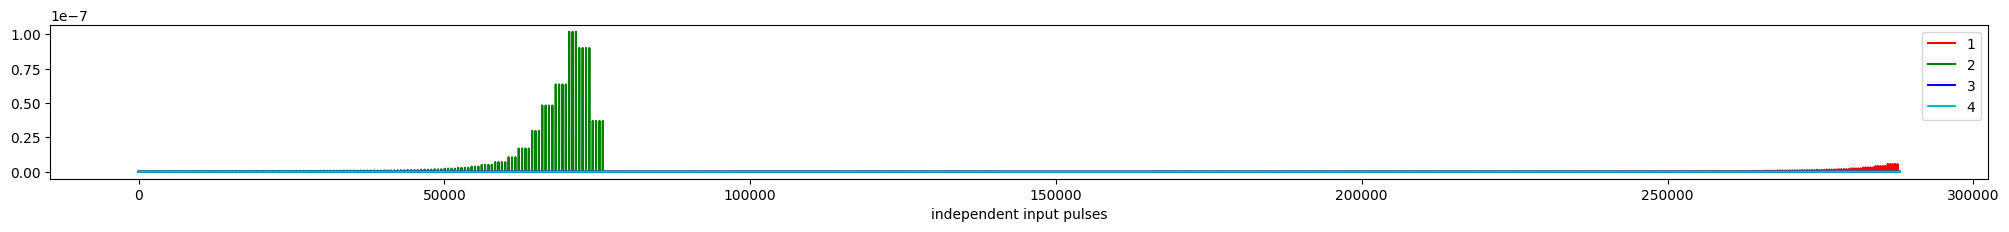

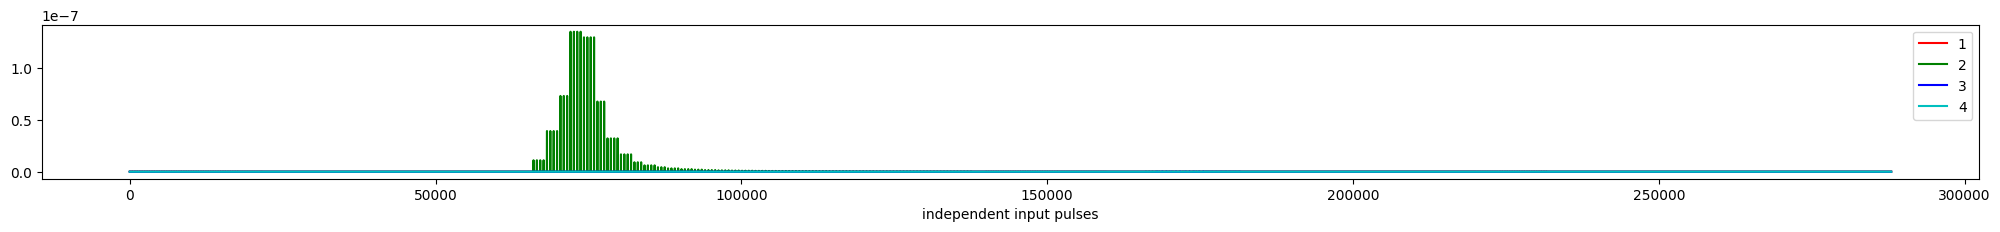

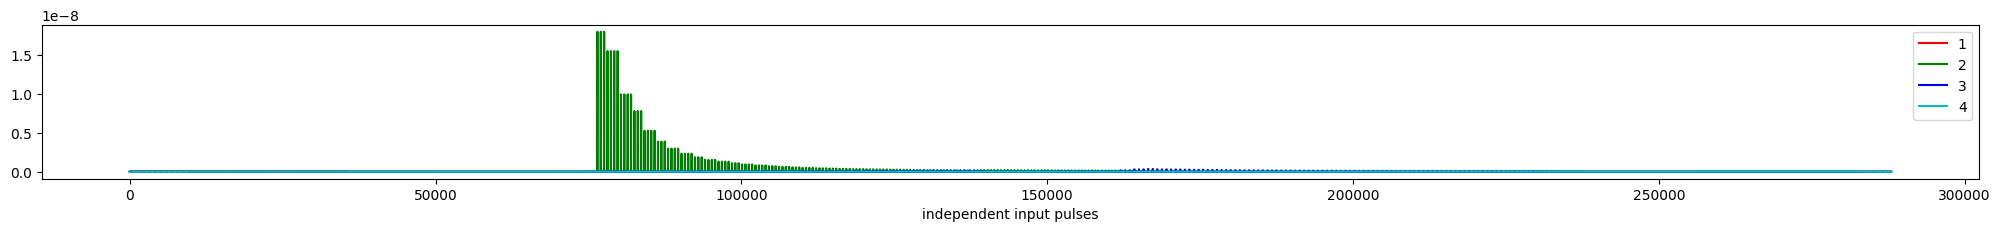

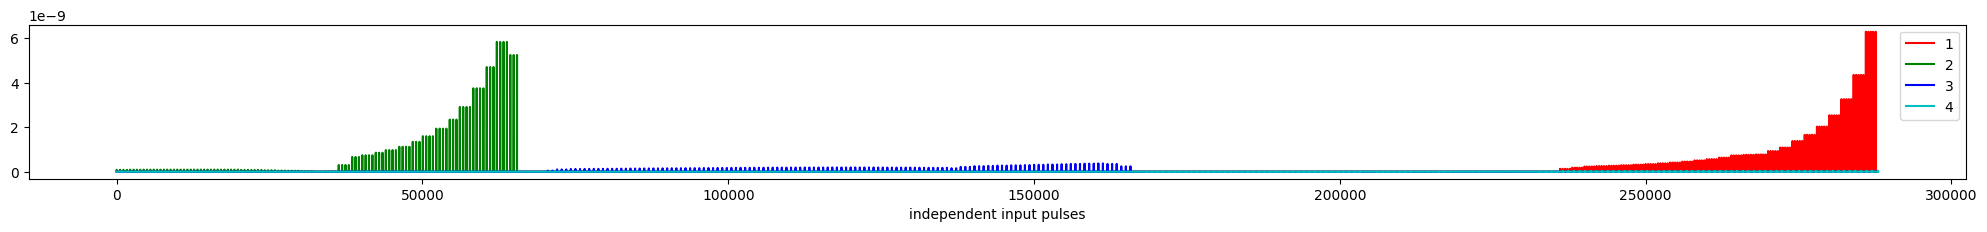

In [33]:
# Display independent Pulse Train 
import matplotlib.pyplot as plt

time_l=[*range(len(pulse_train_f[0]))]
ci=0#8*len(time_l)//9
cf=len(time_l)//1

fig_x , fig_y = 25 , 2
clrs= 'rgbcmyk'

for i in pulse_train:
    plt.figure(figsize=(fig_x , fig_y))
    jdx=0
    for j in i:
        jdx+=1
        plt.plot(time_l[ci:cf],j[ci:cf], color=clrs[jdx-1], label=str(jdx))
    plt.legend()
    plt.xlabel("independent input pulses")
    # plt.ylim([0, ylim])
    # plt.savefig("independent"+str(jdx)+".jpg")
    plt.show()

In [34]:
# # Display interleaved Pulse Train

# import matplotlib.pyplot as plt

# time_l=[*range(len(pulse_train_f[0]))]
# ci=0#len(time)//4
# cf=len(time_l)//1

# fig_x , fig_y = 25 , 2
# clrs= 'rgbcmyk'

# # for i in pulse_train_f:
# for i in pulse_train_f:
#     plt.figure(figsize=(fig_x , fig_y))
#     plt.plot(time_l[ci:cf],i[ci:cf], color=clrs[0]) 
#     plt.xlabel("interleaved pulses")
#     # plt.ylim([0, ylim])
#     # plt.savefig("independent"+str(jdx)+".jpg")
#     plt.show()

In [35]:
# # Aircraft and radar waypoints

# def draw_rectangle(event,x,y,flags,param):
#     global pt_clicked
#     if event == cv2.EVENT_LBUTTONDOWN:
#         pt1 = (x,y)
#         pt_clicked.append(pt1)
#         cv2.circle(frame, center=pt1, radius=3, color=(255,255,255), thickness=-1)

# cv2.namedWindow('Test')
# cv2.setMouseCallback('Test', draw_rectangle) 

# pt_clicked=[]

# frame = np.zeros(img.shape, np.uint8)
# while True:
#     for i in radars:
#         radar_pos=(int(i.position[0]),int(i.position[1]))
#         heading_angle=int(math.degrees(math.atan2(airc_pos[1]-radar_pos[1],airc_pos[0]-radar_pos[0])))#+180
#         heading_noise_range=0
#         i.heading=random.randint(heading_angle-heading_noise_range,heading_angle+heading_noise_range)
#         cv2.circle(frame, radar_pos, 5, (255,0,0), -1)
#         cv2.line(frame, radar_pos, 
#                  (int(radar_pos[0]+(tmp_s_r*math.cos(math.radians(i.heading)))),
#                   int(radar_pos[1]+(tmp_s_r*math.sin(math.radians(i.heading))))), (0,0,255), 2)
#     cv2.imshow('Test', frame)
#     qk=cv2.waitKey(1) & 0xFF
#     if qk == ord('q'):
#         print(pt_clicked)
#         break
#     if qk == ord('r'):
#         pt_clicked=[]
#         frame = np.zeros(img.shape, np.uint8)
#     if qk == ord('s'):
#         print(pt_clicked)
# cv2.destroyAllWindows()

In [36]:
# # Radar coordinates

# def draw_rectangle(event,x,y,flags,param):
#     global pt_clicked
#     if event == cv2.EVENT_LBUTTONDOWN:
#         pt1 = (float(x),float(y))
#         pt_clicked.append(pt1)
#         cv2.circle(frame, center=(int(pt1[0]),int(pt1[1])), radius=5, color=(0,0,255), thickness=-1)

# cv2.namedWindow('Test')
# cv2.setMouseCallback('Test', draw_rectangle) 

# pt_clicked=[]

# frame = np.zeros(img.shape, np.uint8)
# while True:
#     cv2.imshow('Test', frame)
#     qk=cv2.waitKey(1) & 0xFF
#     if qk == ord('q'):
#         print(pt_clicked)
#         break
#     if qk == ord('r'):
#         pt_clicked=[]
#         frame = np.zeros(img.shape, np.uint8)
#     if qk == ord('s'):
#         print(pt_clicked)
# cv2.destroyAllWindows()

In [37]:
# frame = np.zeros((500,2000,3), np.uint8)
# while True:
#     cv2.imshow('Test', frame)
#     qk=cv2.waitKey(1) & 0xFF
#     if qk == ord('q'):
#         break
# cv2.destroyAllWindows()